# Computer Lab 4: scRNASeq Data Analysis Workflow

Welcome to the practical session of [Data-Driven Life Sciences course module 4](https://ddls.aicell.io/course/ddls-2025/module-4/lab/).

You will be guided through a scRNA-seq data analysis workflow using PBMC samples
from COVID-19 patients and healthy controls.

This lab is divided into two parts. In the first part, you will run the analysis workflow directly in the notebook. In the second part, you will build an MCP (Model-Context-Protocol) tool to autonomously identify genes that are differentially expressed between cell populations.

## 🧭 Quick AI Warm-up: Single-Cell Analysis (≈10 min)

Use your AI assistant to ask and summarize answers to these **basic questions**.
👉 Goal: build a simple mental map before the computer lab.

---

1. What is single-cell RNA sequencing, and how is it different from bulk RNA-seq?

2. What are the **main steps** in a typical single-cell RNA-seq analysis workflow?

3. What is **quality control (QC)** in single-cell data, and what metrics are used?

4. Why do we use **normalization** and **dimensionality reduction** (e.g. PCA, UMAP)?

5. What can we do with single-cell data? (Examples: clustering, cell type annotation, gene expression analysis)

6. What are the main **Python tools** (e.g. Scanpy), and what is an **AnnData object**?

---

### Instructions

* Spend about **1–2 minutes per question**.
* Write down a **short 1-sentence summary** for each.
* If time allows, ask for a **tiny Python example** (e.g., loading data in Scanpy).

`⭐ Edit this cell to write your answers below:`

1.

2.

3.

4.

5.

6.

## Save the notebook to your Module 4 folder in Google Drive

Before you start, copy this notebook to your Google Drive:

`File` -> `Save a copy in Drive`

Make sure you open the copied notebook. You can close the tab with the original notebook.

Next, move the copied notebook to your Module 4 folder in Google Drive:

`File` -> `Move` -> Go up to `My Drive` -> Select your `DDLS-Course` folder -> Create a new folder named `Module4` -> `Select folder`


## Mount Google Drive Folder

Mounting your Google Drive folder allows your Colab notebook to access files stored in your Google Drive. This is useful for loading datasets, saving results, or accessing other files you need for your work.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

If you copied and saved the notebook correctly, you should now see this notebook in your Google Drive under `/content/drive/MyDrive/DDLS-Course/Module4/`.

In [ ]:
!ls -lh

## scRNA-seq analysis workflow steps:

In this notebook, you will perform a standard scRNASeq data analysis using the following steps:

1. **Loading the Data:**
   - Import raw scRNASeq data into the environment for further processing and analysis.

2. **Quality Control:**
   - Evaluate the data quality by filtering out low-quality cells, such as those with high mitochondrial content or low gene counts.

3. **Filtering:**
   - Remove cells and genes that do not meet quality thresholds, ensuring the analysis uses only relevant data.

4. **Doublet Detection:**
   - Identify and exclude potential doublets (instances where two cells are mistakenly captured as one), which can skew the results.

5. **Cell Cycle Regression:**
   - Correct for cell cycle effects to reduce their influence on subsequent analyses, leading to more accurate clustering of cells.

6. **Feature Selection:**
   - Identify highly variable genes that are most informative for distinguishing different cell states or types.

7. **Data Integration (Batch Correction):**
   - Merge data from multiple samples, correcting for technical variations between them to allow accurate comparison.

8. **Dimensionality Reduction:**
   - Simplify the data using methods like PCA or UMAP to reveal patterns and make the data easier to visualize and interpret.

9. **Differential Expression:**
   - Identify genes that are differentially expressed between cell populations, which helps define distinct cell types or states.

This workflow will guide you through analyzing scRNASeq data, helping you identify critical expression differences between patient and healthy control samples.

_The analysis workflow in this notebook was created by [Nima Rafati](https://www.uu.se/en/contact-and-organisation/staff?query=N11-1726), with materials primarily derived from the scRNASeq workshop created at NBIS (Åsa Björklund, Paulo Czarnewski, Susanne Reinsbach, Roy Francis). To access the full course content, please visit [here](https://nbisweden.github.io/workshop-scRNAseq/)._


In [ ]:
#@title Install dependencies
#@markdown You can run the notebook using **CPU**.
#@markdown In the menu above do: Runtime --> Change runtime type --> Hardware accelerator (set to CPU)

#@markdown **Press play to install.** This will take about 2 minutes.

#@markdown (Note: You do NOT need to restart the runtime afterwards.)

!pip install --upgrade pip
!pip install jedi
!pip install numpydoc
!pip install bbknn
!pip install geopandas
!pip install harmonypy
!pip install leidenalg
!pip install matplotlib-scalebar
!pip install matplotlib-venn
!pip install napari-matplotlib
!pip install pybiomart
!pip install scanpy
!pip install scrublet

### Importing packages

We will first import all packages we will use in this notebook.


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# single cell analysis
import scanpy as sc
import scanpy.external as sce

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# Integration
import harmonypy as hm
import bbknn

# Clustering
import leidenalg # Leiden clustering
from sklearn.cluster import KMeans # KMeans clustering
from sklearn.metrics import adjusted_rand_score  # ARI
from sklearn.cluster import AgglomerativeClustering # Agglomerative clustering


import pybiomart # for gene annotation
import warnings
import os # for file handling
import urllib.request  # for data download

warnings.simplefilter(action='ignore', category=Warning)

We then set the Matplotlib plotting defaults for all plots and print versions of python packages in the current environment.  

In [ ]:
sc.settings.set_figure_params(dpi = 90, facecolor='white')
# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3
sc.logging.print_header()

*****

# Part I — Classic scRNASeq Workflow in Jupyter


## Loading the Data

In this computer lab, we will use 8 PBMC (Peripheral Blood Mononuclear Cells) datasets from four COVID-19 patients and four healthy controls, generated using 10x Genomics technology. To make the analysis more manageable, each dataset has been subsampled to 1500 cells per sample.  

The datasets are provided as `.h5` files hosted at `uppmax.uu.se`. During the setup, the following steps will be performed automatically:

- Download the 8 datasets to `/content/drive/MyDrive/DDLS-Course/Module4/data/covid/` (if not already present locally).  
- Load each dataset with **Scanpy** (`read_10x_h5`) and ensure unique gene names.  
- Annotate metadata for sample identity (`sample`) and condition (`type`: *Covid* or *Ctrl*).  
- Merge all samples into one combined `AnnData` object for downstream analysis.  


In [ ]:
# Base URL and local paths
url_data = "https://export.uppmax.uu.se/naiss2023-23-3/workshops/workshop-scrnaseq/covid/"
path_data = "/content/drive/MyDrive/DDLS-Course/Module4/data/covid/"
path_results = "/content/drive/MyDrive/DDLS-Course/Module4/results/"

os.makedirs(path_data, exist_ok=True)
os.makedirs(path_results, exist_ok=True)

# File list
files_to_download = {
    "covid_1":    "ncov_pbmc_1.h5",
    "covid_15":   "ncov_pbmc_15.h5",
    "covid_16":   "ncov_pbmc_16.h5",
    "covid_17":   "ncov_pbmc_17.h5",
    "ctrl_5":     "normal_pbmc_5.h5",
    "ctrl_13":    "normal_pbmc_13.h5",
    "ctrl_14":    "normal_pbmc_14.h5",
    "ctrl_19":    "normal_pbmc_19.h5"
}

# Download if missing
for fname in files_to_download.values():
    fpath = os.path.join(path_data, fname)
    if not os.path.exists(fpath):
        print(f"Downloading {fname}...")
        urllib.request.urlretrieve(url_data + fname, fpath)
    else:
        print(f"File already exists: {fname}")

# Load all datasets and add metadata
datasets = []
for sample_name, fname in files_to_download.items():
    fpath = os.path.join(path_data, fname)
    print(f"Reading {fname}...")
    ad = sc.read_10x_h5(fpath)
    ad.var_names_make_unique()
    # Add metadata
    ad.obs["type"] = "Covid" if sample_name.startswith("covid") else "Ctrl"
    ad.obs["sample"] = sample_name
    datasets.append(ad)

# Merge into one AnnData
adata = datasets[0].concatenate(*datasets[1:])

# Clean up
del datasets

print("Final AnnData object shape:", adata.shape)
adata

File already exists: ncov_pbmc_1.h5
File already exists: ncov_pbmc_15.h5
File already exists: ncov_pbmc_16.h5
File already exists: ncov_pbmc_17.h5
File already exists: normal_pbmc_5.h5
File already exists: normal_pbmc_13.h5
File already exists: normal_pbmc_14.h5
File already exists: normal_pbmc_19.h5
Reading ncov_pbmc_1.h5...
Reading ncov_pbmc_15.h5...
Reading ncov_pbmc_16.h5...
Reading ncov_pbmc_17.h5...
Reading normal_pbmc_5.h5...
Reading normal_pbmc_13.h5...
Reading normal_pbmc_14.h5...
Reading normal_pbmc_19.h5...
Final AnnData object shape: (12000, 33538)


AnnData object with n_obs × n_vars = 12000 × 33538
    obs: 'type', 'sample', 'batch'
    var: 'gene_ids', 'feature_types', 'genome'

### Working with AnnData

Scanpy loads the 10x Genomics datasets into an **AnnData** object, which is the core data structure used throughout the analysis.  
An AnnData object is designed for single-cell omics data and stores:  

- The **expression matrix** (cells × genes).  
- **Annotations** of cells (`.obs`) and genes (`.var`).  
- **Additional layers** such as embeddings, transformations, and analysis results.  

This makes it easy to keep all data and metadata together in one container.  

*(See the schema illustration below for how AnnData is organized.)*


### ⭐ **Task:** Explore the AnnData object

Before moving on, take a few minutes to explore the `adata` object you just created.  
Answer the following questions by running Python commands in the notebook:

1. What is the **shape** of the expression matrix (cells × genes)?  
2. What metadata is stored for the **cells** in `adata.obs`?  
3. What metadata is stored for the **genes** in `adata.var`?  
4. How many cells come from *Covid* samples vs. *Ctrl* samples?


In [ ]:
# ⭐ Write your code to explore the anndata object

`⭐ Edit this cell to write your answers below:`

1.
2.
3.
4.

## Quality Control (QC)
Here we generate some metrics which helps us to evaluate the quality of the dataset:
- `total_counts`:  Total number of molecules in a cell.  
- `n_genes_by_counts`: Number of genes with at least one count in a cell.  
- `pct_counts_mt`: The percentage of reads mapped to mitochondrial genes.  
- `pct_counts_ribo`: The percentage of reads mapped to ribosomal genes.  
- `pct_counts_hb`: The percentage of reads mapped to hemoglobin genes (blood cells).  

In [ ]:
# mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-')
# ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
# hemoglobin genes.
adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P|E|S)]"))

adata.var

gene_ids    feature_types  genome     mt   ribo     hb
MIR1302-2HG  ENSG00000243485  Gene Expression  GRCh38  False  False  False
FAM138A      ENSG00000237613  Gene Expression  GRCh38  False  False  False
OR4F5        ENSG00000186092  Gene Expression  GRCh38  False  False  False
AL627309.1   ENSG00000238009  Gene Expression  GRCh38  False  False  False
AL627309.3   ENSG00000239945  Gene Expression  GRCh38  False  False  False
...                      ...              ...     ...    ...    ...    ...
AC233755.2   ENSG00000277856  Gene Expression  GRCh38  False  False  False
AC233755.1   ENSG00000275063  Gene Expression  GRCh38  False  False  False
AC240274.1   ENSG00000271254  Gene Expression  GRCh38  False  False  False
AC213203.1   ENSG00000277475  Gene Expression  GRCh38  False  False  False
FAM231C      ENSG00000268674  Gene Expression  GRCh38  False  False  False

[33538 rows x 6 columns]

Now we calculate some QC metrics, such as percentage of mitochondrial genes.

In [ ]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)
adata

AnnData object with n_obs × n_vars = 12000 × 33538
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

Now we plot the QC metrics.  

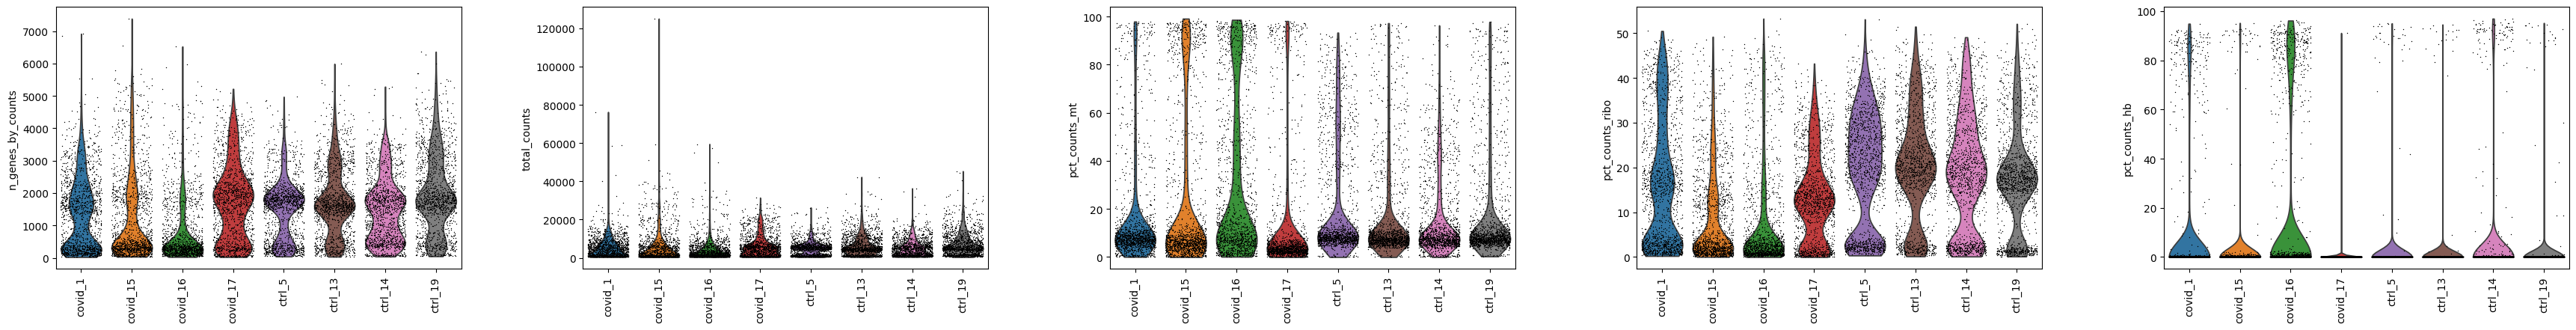

In [ ]:
sc.pl.violin(adata,
             ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'sample', rotation= 90,
             multi_panel=False)

### ⭐ **Task**

Samples `covid_15` & `covid_16` show distinct behaviour: fewer detected genes and more mitochondrial genes. Please explain what could cause this.

`⭐ Edit this cell to write your answers below:`

-

 In addition to above metrics we can plot `total_counts` vs ` n_genes_by_count` in a scatterplot.  

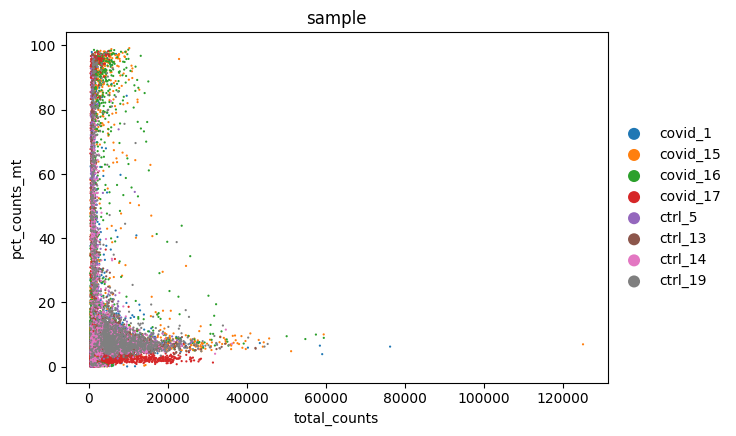

In [ ]:
sc.pl.scatter(adata, x = 'total_counts', y = 'pct_counts_mt', color = 'sample')

## Filtering

For downstream analysis, it is important to remove noise from the dataset. In this case we can remove cells with few number of detected genes, and thus we keep cells with at least **200** detected genes. Also to have enough statistical power we need to have enough observation for given genes and thus we keep genes that are expressed in at least **three** cells.

In [ ]:
sc.pp.filter_cells(adata, min_genes = 200)
sc.pp.filter_genes(adata, min_cells = 3)

print("Remaining cells", adata.n_obs)

Remaining cells 7430


### ⭐ **Task**

Isn't it surprising that many genes have been filtered? What do you think could be the reason for this?

`⭐ Edit this cell to write your answers below:`

-

We can also plot highly expressed genes using `scanpy.pl.highest_expr_genes` methods.

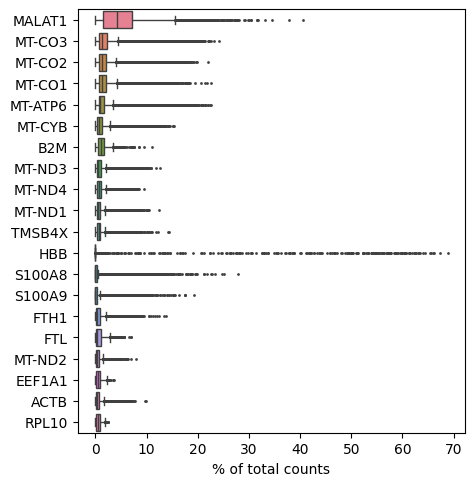

In [ ]:
sc.pl.highest_expr_genes(adata, n_top=20)

_MALAT1_ shows highest expression in this dataset together with mitochondrial genes. _MALAT1_ is a nuclear lincRNA and its high expression may not be surprising, because it is frequently detected in poly-A captured scRNASeq data. In other word, it may be technical issue. Regarding mitochondrial/ribosomal genes, we can filter cells with high expression of these genes. High expression of mitochondrial gene may be indicative of high mortality of cells.

This dataset does not show very high fraction though and by considering `20%` threshold for mitochondrial we will have reasonable number of cells to do downstream analysis.

High fraction of ribosomal genes may also indicate low-quality cells. In this dataset the fraction is not high and we can be less stringent by applying a cut-off of `5%`.   

In [ ]:
adata = adata[adata.obs['pct_counts_mt'] < 20, :]
adata = adata[adata.obs['pct_counts_ribo'] > 5, :]

print("Remaining cells", adata.n_obs)

Remaining cells 7430


Let's look at the data after filtering.  

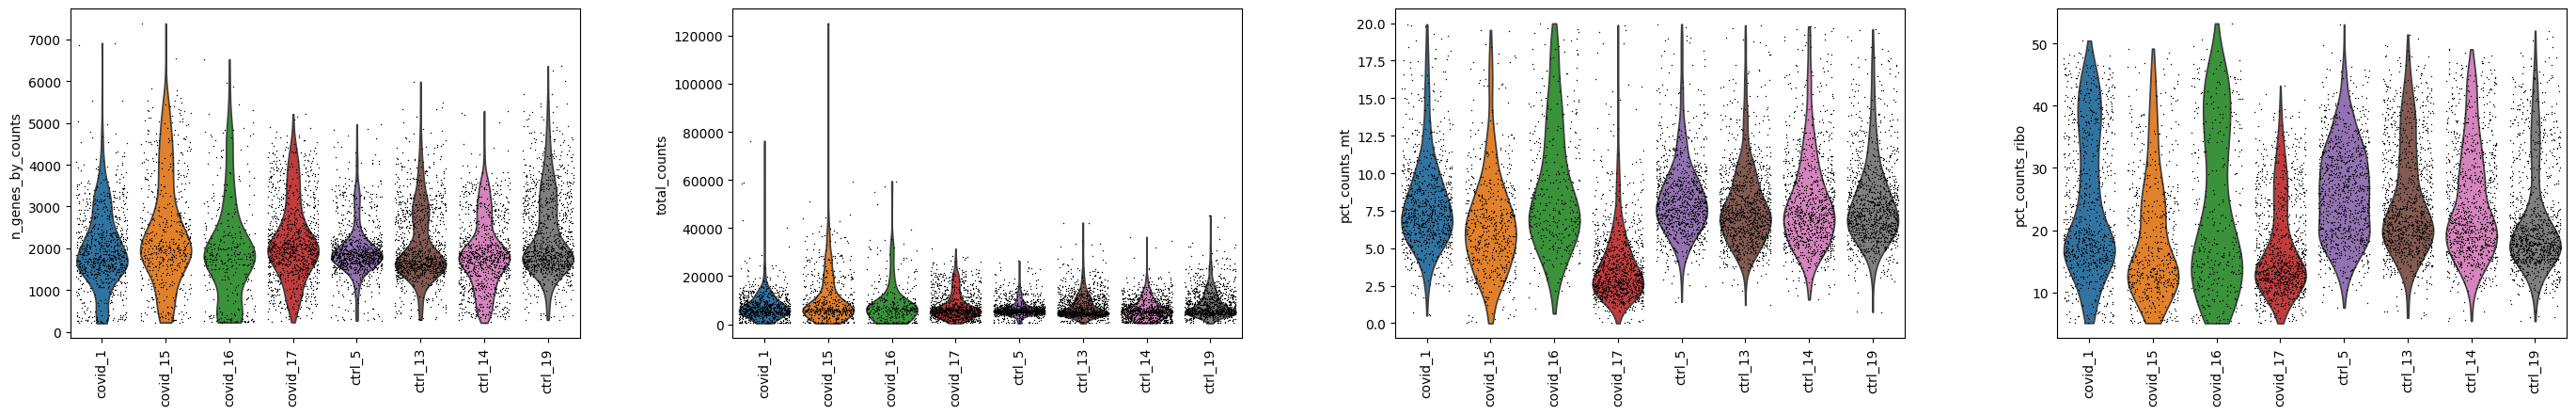

In [ ]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], jitter=0.4, groupby = 'sample', rotation= 90, multi_panel=False)

### ⭐ **Task**

Please explain what has changed in the filtered data distribution compared to the unfiltered data distribution.

`⭐ Edit this cell to write your answers below:`

-

### Filtering genes

As the level of expression of mitochondrial and MALAT1 genes are judged as mainly technical, it can be wise to remove them from the dataset before any further analysis. In this case we will also remove the HB genes as HBB has very high expression in some cells.

In [ ]:
malat1 = adata.var_names.str.startswith('MALAT1')
# we need to redefine the mito_genes since they were first
# calculated on the full object before removing low expressed genes.
mito_genes = adata.var_names.str.startswith('MT-')
hb_genes = adata.var_names.str.contains('^HB[^(P|E|S)]')

remove = np.add(mito_genes, malat1)
remove = np.add(remove, hb_genes)
keep = np.invert(remove)

adata = adata[:,keep]


print("Remaining genes", adata.n_vars)

Remaining genes 19094


Now we can save the data after filtering

In [ ]:
# Saving filtered data
adata.write(os.path.join(path_results, "covid_filtered.h5ad"))

## Samples Sex

The sex of the samples is crucial metadata that should be taken into account in the analysis to control for any sex-associated effects. Moreover, inferring the sex of samples using sequencing data can be a good sanity check for potential mislabelling and so on. By evaluating mapping to following features we can determine the sex:  
- X-inactive specific transcript (_XIST_).  
- Y chromosome.  


We can extract the information of these features from annotation file (gtf) or using Biomart in Ensembl. In python (`pybiomart`) you can also directly connect to ensembl database and extract annotation information.    

For gtf format you can read [here](https://nbisweden.github.io/workshop-RNAseq/2403/lab_download.html) (from RNASeq workshop organized by NBIS)

In [ ]:
annot = sc.queries.biomart_annotations("hsapiens", ["ensembl_gene_id", "external_gene_name", "start_position", "end_position", "chromosome_name"], ).set_index("external_gene_name")
annot

ensembl_gene_id  start_position  end_position  \
external_gene_name                                                  
MT-TF               ENSG00000210049             577           647   
MT-RNR1             ENSG00000211459             648          1601   
MT-TV               ENSG00000210077            1602          1670   
MT-RNR2             ENSG00000210082            1671          3229   
MT-TL1              ENSG00000209082            3230          3304   
...                             ...             ...           ...   
AHCYL1              ENSG00000168710       109984765     110023742   
JMJD4               ENSG00000081692       227730412     227735411   
TNFRSF14            ENSG00000157873         2554244       2565382   
DAP3                ENSG00000132676       155687833     155739014   
YY1AP1              ENSG00000163374       155659446     155689334   

                   chromosome_name  
external_gene_name                  
MT-TF                           MT  
MT-RNR1                         MT  
MT-TV                           MT  
MT-RNR2                         MT  
MT-TL1                          MT  
...                            ...  
AHCYL1                           1  
JMJD4                            1  
TNFRSF14                         1  
DAP3                             1  
YY1AP1                           1  

[86369 rows x 4 columns]

With the information of the features we can now extract fraction of reads that mapped to chromosome Y:

In [ ]:
chrY_genes = adata.var_names.intersection(annot.index[annot.chromosome_name == "Y"])
chrY_genes

adata.obs['percent_chrY'] = np.sum(
    adata[:, chrY_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1 * 100

We can directly extract the expression of _XIST_ from `anndata`  object.  

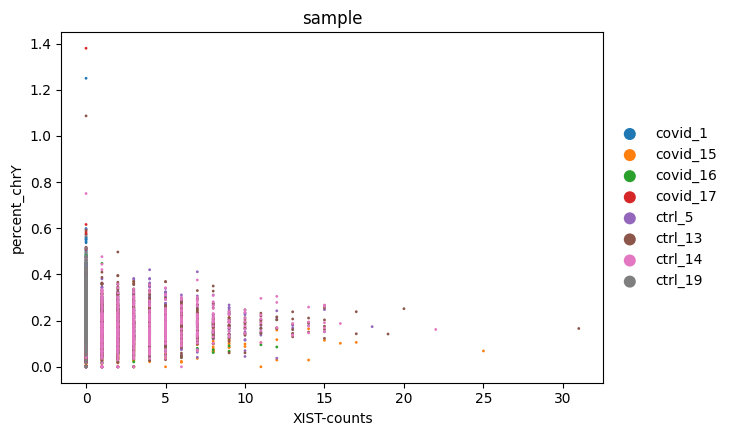

In [ ]:
# color inputs must be from either .obs or .var, so add in XIST expression to obs.
adata.obs["XIST-counts"] = adata.X[:,adata.var_names.str.match('XIST')].toarray()

sc.pl.scatter(adata, x='XIST-counts', y='percent_chrY', color="sample")

Now we can plot _XIST_ expression for all the samples

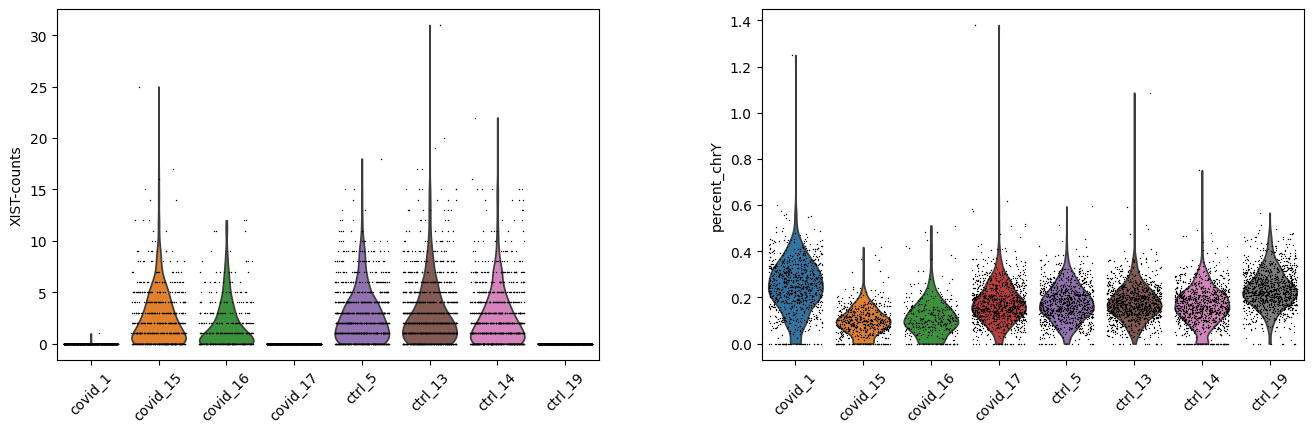

In [ ]:
sc.pl.violin(adata, ["XIST-counts", "percent_chrY"], jitter=0.4, groupby = 'sample', rotation= 45)

### ⭐ **Task**

Can you see which samples are feamle/male?

`⭐ Edit this cell to write your answers below:`

-

## Doublet detection

Doublets of cells are is a common feature in scRNASeq where cells in the same well/droplet are sequenced together. They are either homotypic (from the same cell type) or heterotypic (from different cell types). Dependent on the technology, there can be an expected proportion of doublets. In 10x technology this proportion is linearly correlated with the number of loaded cells.

| Multiplet Rate (%) | # of Cells Loaded | # of Cells Recovered |
|--------------------|-------------------|----------------------|
| ~0.4%              | ~870              | ~500                 |
| ~0.8%              | ~1700             | ~1000                |
| ~1.6%              | ~3500             | ~2000                |
| ~2.3%              | ~5300             | ~3000                |
| ~3.1%              | ~7000             | ~4000                |
| ~3.9%              | ~8700             | ~5000                |
| ~4.6%              | ~10500            | ~6000                |
| ~5.4%              | ~12200            | ~7000                |
| ~6.1%              | ~14000            | ~8000                |
| ~6.9%              | ~15700            | ~9000                |
| ~7.6%              | ~17400            | ~10000               |


One of the approaches to detect doublets, is by simulating doublets. Artificial doublets are randomly subsampled in pairs and their gene expression is averaged to obtain doublets counts. The new artifical doublets are projected together with the original cells into a lower dimensional principle space. Then a doublet score based on numnber of artificial doublet neighbors is computed in the k nearest neighbour graph.

Most such packages need an assumption about the number/proportion of expected doublets in the dataset. The data you are using is subsampled, but the original datasets contained about 5 000 cells per sample, hence we can assume that they loaded about 9 000 cells and should have a doublet rate at about 4%.

`scrublet`  is a tool which is used to identify doublets. This tool works with raw counts saved in `adata.X`.   

**Note: that doublet detection should be done for each sample separately.**   

To do that we will split the data in a loop and run ` scrublet`  for each sample and add the detected doublets to the `adata`  object.     

![doublet_detection.jpeg](https://ddls.aicell.io/course/ddls-2024/module-3/doublet_detection.jpeg)

_Artificial doublets are randomly subsampled in pairs and their gene expression is averaged to obtain doublets counts. The new artifical doublets are projected together with the original cells into a lower dimensional principle space. Then a doublet score based on numnber of artificial doublet neighbors is computed in the k nearest neighbour graph._

In [ ]:
import scrublet as scr

# split per batch into new objects.
batches = adata.obs['sample'].cat.categories.tolist()
alldata = {}
for batch in batches:
    tmp = adata[adata.obs['sample'] == batch,]
    print(batch, ":", tmp.shape[0], " cells")
    scrub = scr.Scrublet(tmp.X)
    out = scrub.scrub_doublets(verbose=False, n_prin_comps = 20)
    alldata[batch] = pd.DataFrame({'doublet_score':out[0],'detected_doublets':out[1]},index = tmp.obs.index)
    print(alldata[batch].detected_doublets.sum(), " detected_doublets")

# add predictions to the adata object.
scrub_pred = pd.concat(alldata.values())
adata.obs['doublet_scores'] = scrub_pred['doublet_score']
adata.obs['detected_doublets'] = scrub_pred['detected_doublets']

print('Total doublets:' , sum(adata.obs['detected_doublets']))

covid_1 : 900  cells
23  detected_doublets
covid_15 : 598  cells
4  detected_doublets
covid_16 : 373  cells
2  detected_doublets
covid_17 : 1101  cells
17  detected_doublets
ctrl_5 : 1052  cells
26  detected_doublets
ctrl_13 : 1173  cells
54  detected_doublets
ctrl_14 : 1063  cells
22  detected_doublets
ctrl_19 : 1170  cells
36  detected_doublets
Total doublets: 184


When two cells are sequenced with one cell barcode, we should expect that there is high number of detected cells under single cell (barcode).

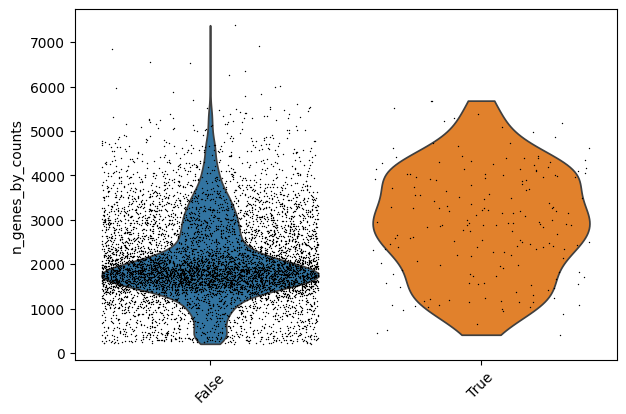

In [ ]:
# add in column with singlet/doublet instead of True/Fals
%matplotlib inline

adata.obs['doublet_info'] = adata.obs["detected_doublets"].astype(str)
sc.pl.violin(adata, 'n_genes_by_counts', jitter=0.4, groupby = 'doublet_info', rotation=45)
adata.write(os.path.join(path_results, "covid_filtered_removed_doublets.h5ad"))

In order to show the distribution of doublets among all the cells, we will do the following step:
- Normalize and scale the data.  
- Dimensionality reduction (you will read further below).  
- Creating UMAP (you will read further below).  

**Note: When you normalize the data the `data`  slot will be overwritten with the normalized counts.**  
In order to have a copy of the raw data you can save it in a new variable (`adata.raw`).  

If you want to identify the distribution of doublet among cells in reduced dimenstional space, run the following chunk.  
We will do this in dionsionality reduction step, further down.

In [ ]:
adata = sc.read_h5ad(os.path.join(path_results, "covid_filtered_removed_doublets.h5ad"))

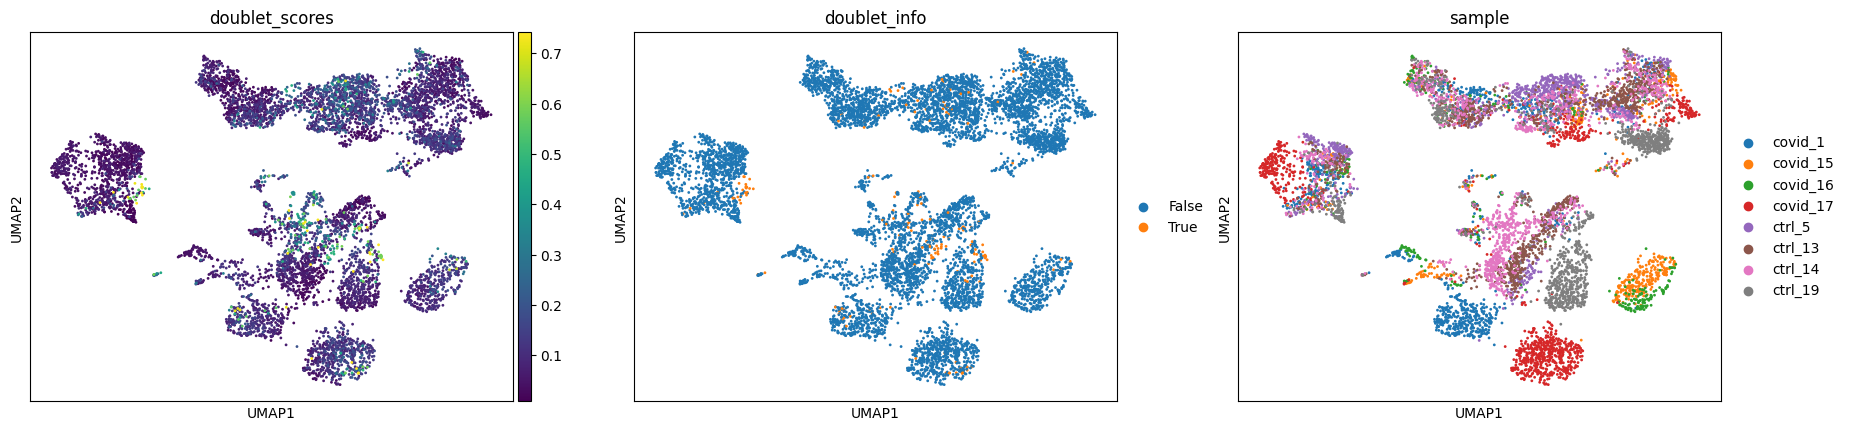

In [ ]:
# save normalized counts in raw slot.
adata.raw = adata
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# normalize to depth 10 000
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# logaritmize
sc.pp.log1p(adata)

# Identifying highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['doublet_scores','doublet_info','sample'])

Now we can remove all the detected doublets

In [ ]:
# also revert back to the raw counts as the main matrix in adata
adata = adata.raw.to_adata()

adata = adata[adata.obs['doublet_info'] == 'False',:]
print(adata.shape)
#Saving the filtered object
adata.write_h5ad(os.path.join(path_results, "covid_filtered_removed_doublets.h5ad"))


(7246, 19094)


## Cell cycle state

There are gene markers by which we can score the cell cycle state. The algorithm calculates the difference of mean expression of the given list and the mean expression of reference genes. To build the reference, the function randomly chooses a bunch of genes matching the distribution of the expression of the given list. Cell cycle scoring adds three slots in the metadata, a score for S phase, a score for G2M phase and the predicted cell cycle phase.  

First read the file with cell cycle genes, from Regev lab and split into S and G2M phase genes. We first download the file.  

In [ ]:
remote_file = 'https://export.uppmax.uu.se/naiss2023-23-3/workshops/workshop-scrnaseq/regev_lab_cell_cycle_genes.txt'
path_file = os.path.join(path_results, 'regev_lab_cell_cycle_genes.txt')
if not os.path.exists(path_file):
    urllib.request.urlretrieve(remote_file, path_file)

In [ ]:
cell_cycle_genes = [x.strip() for x in open(os.path.join(path_results, "regev_lab_cell_cycle_genes.txt"))]
print("Number of cell cycle genes:", len(cell_cycle_genes))

cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print("Available number of cell cycle genes:", len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

Number of cell cycle genes: 97
Available number of cell cycle genes: 94


The data is already normalized and we can perform cell cycle scoring. The function is actually a wrapper to `sc.tl.score_gene_list`, which is launched twice, to score separately S and G2M phases. Both `sc.tl.score_gene_list` and` sc.tl.score_cell_cycle_genes` are a port from Seurat and are supposed to work in a very similar way.

In [ ]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

Let's check the cell cycle scores in plots.  

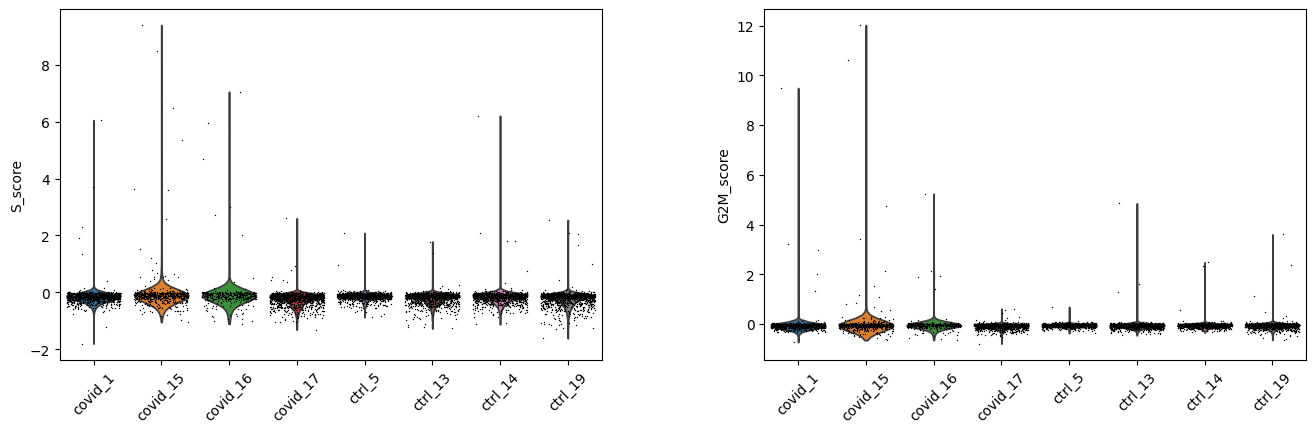

In [ ]:
sc.pl.violin(adata, ['S_score', 'G2M_score'], jitter=0.4, groupby = 'sample', rotation=45)

In this case it looks like we only have a few cycling cells in these datasets and we do not need to regress out the cell cycle effect.

Scanpy does an automatic prediction of cell cycle phase with a default cutoff of the scores at zero. As you can see this does not fit this data very well, so be cautios with using these predictions. Instead we suggest that you look at the scores.

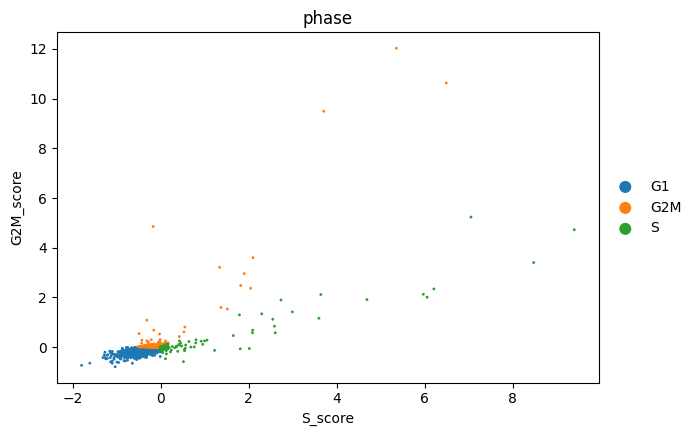

In [ ]:
sc.pl.scatter(adata, x='S_score', y='G2M_score', color="phase")

In [ ]:
adata.write_h5ad(os.path.join(path_results, "covid_filtered_removed_doublets_cell_cycle.h5ad"))

## Feature selection
To reduce the feature dimension and redundancy as well as avoding overfitting in downstream analysis we perform feature selection. By this approach we focus on set of genes that can potentially explain biological variation in the dataset.  

Highly variable genes: 2616


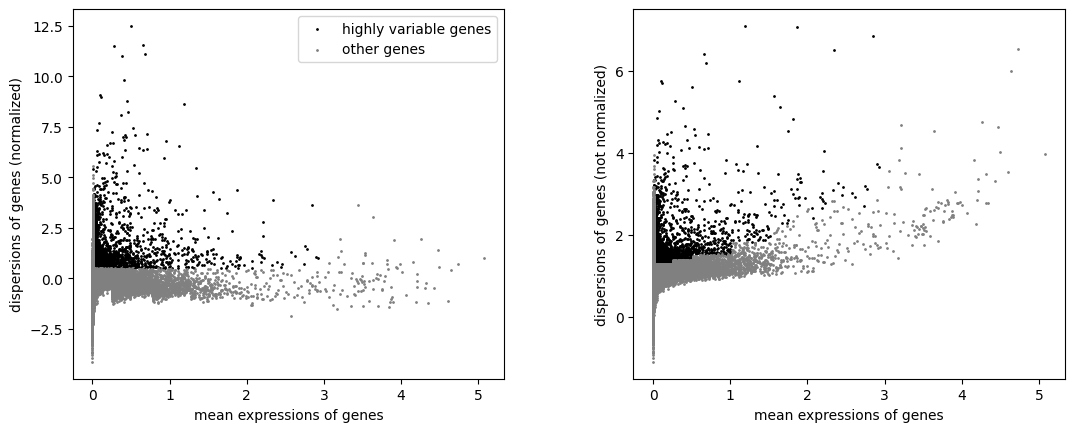

In [ ]:
# Load the data filtered data
adata = sc.read_h5ad(os.path.join(path_results, "covid_filtered_removed_doublets_cell_cycle.h5ad"))
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# logaritmize
sc.pp.log1p(adata)


# store normalized counts in the raw slot,
# we will subset adata.X for variable genes, but want to keep all genes matrix as well.
adata.raw = adata

# Identifying highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

print("Highly variable genes: %d"%sum(adata.var.highly_variable))

#plot variable genes
sc.pl.highly_variable_genes(adata)

# subset for variable genes in the dataset
adata = adata[:, adata.var['highly_variable']]

## Diomensionality reduction

After feature selection, we can still reduce the complexity (dimenstion) of the data using different algorithms:   
- PCA (Linear)  
- t-SNE & UMAP (non-linear)  

### PCA
To do this we first perform PCA and then plot the PCs (PC1 - PC7)  

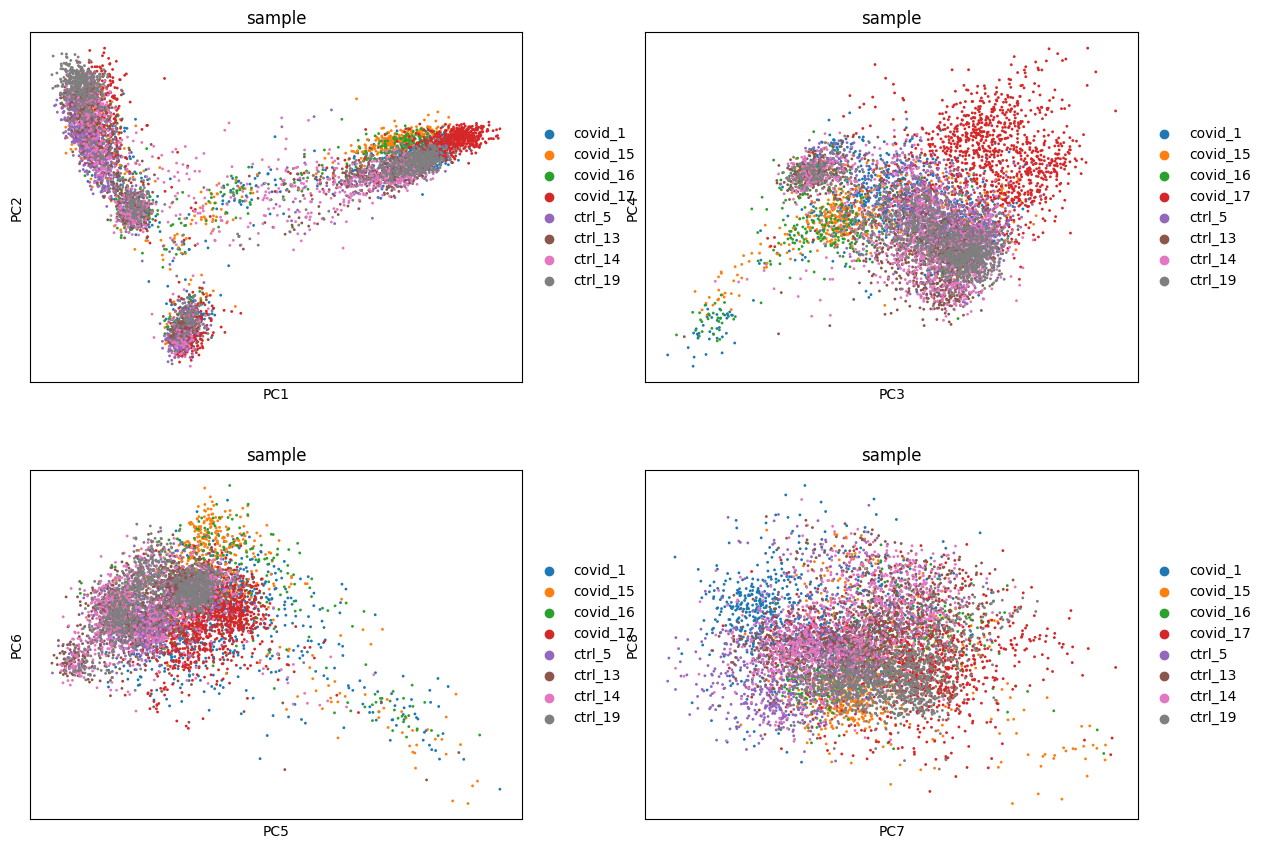

In [ ]:
# Calculating PCs
sc.tl.pca(adata, svd_solver='arpack')
# Visualising PCs
sc.pl.pca(adata, color='sample', components = ['1,2','3,4','5,6','7,8'], ncols=2)

You can also check which genes contributed to the capture variation in each PCs  

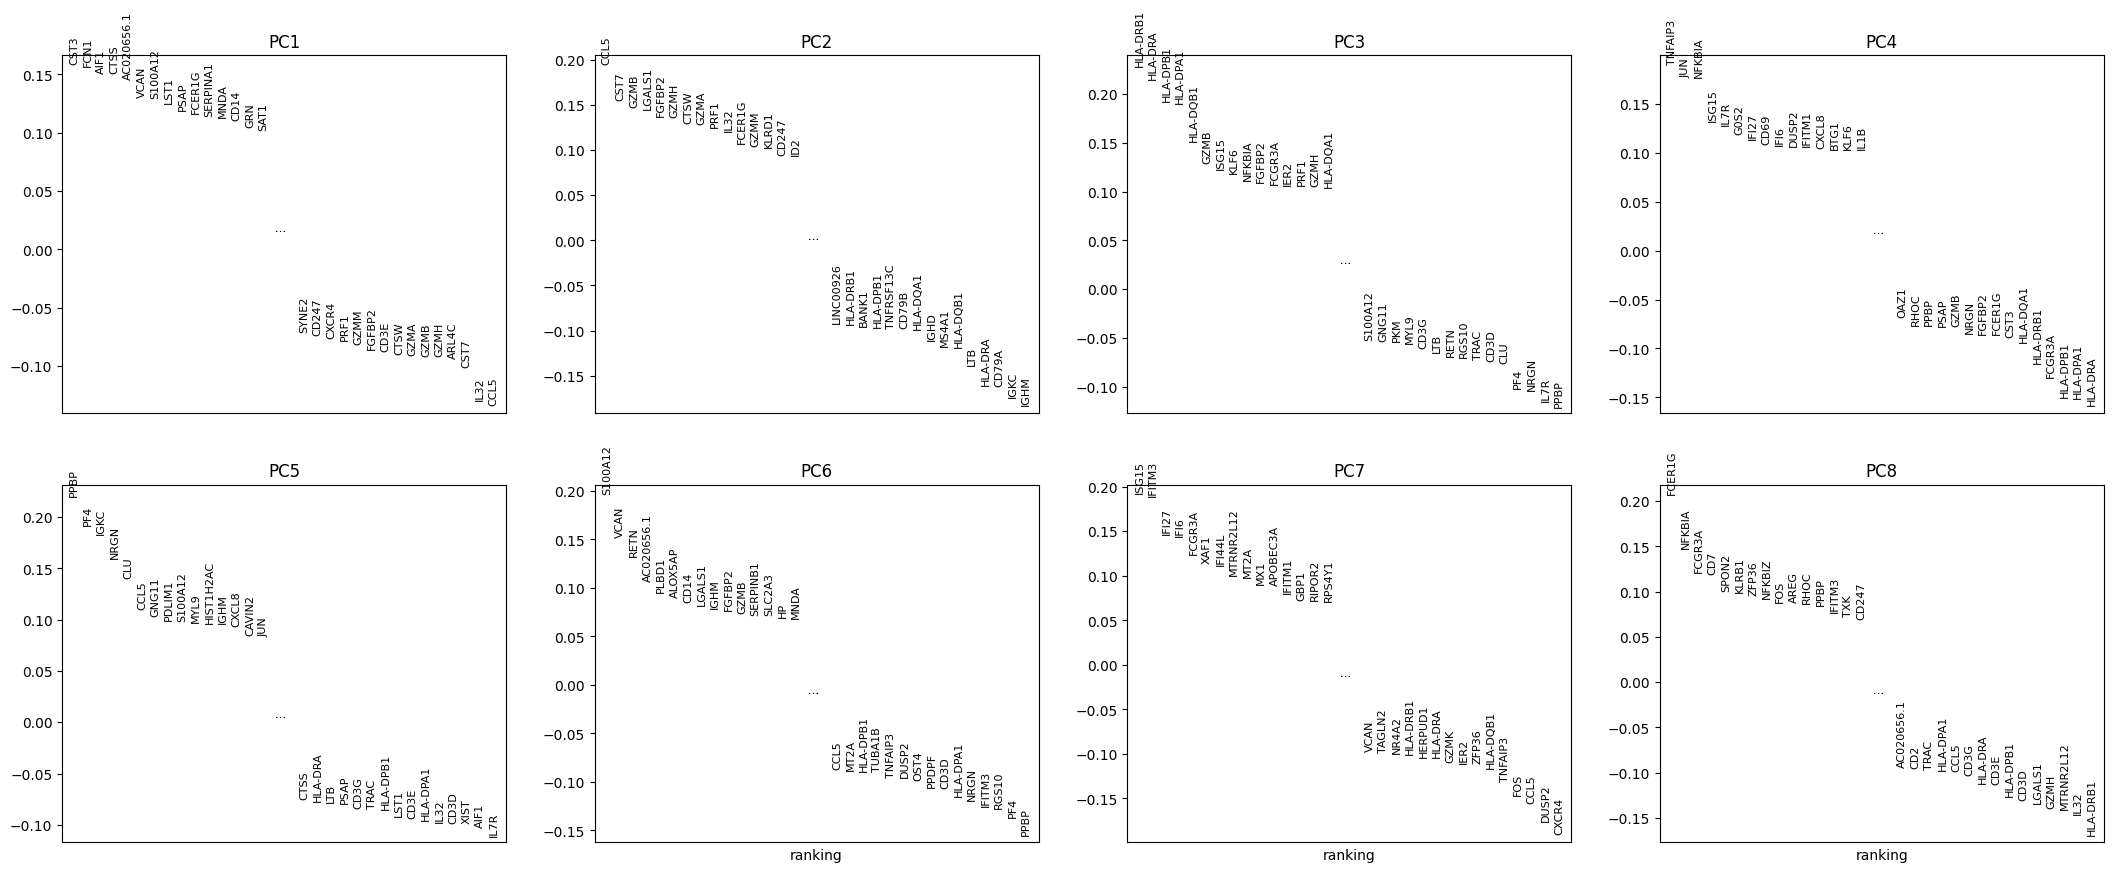

In [ ]:
sc.pl.pca_loadings(adata, components=[1,2,3,4,5,6,7,8])
# OBS! only plots the positive axes genes from each PC!!

Remember that not all the PCs can capture large fraction of the variance and can be discarded. By ranking the PCs we can identify elbow pattern and exclude them.

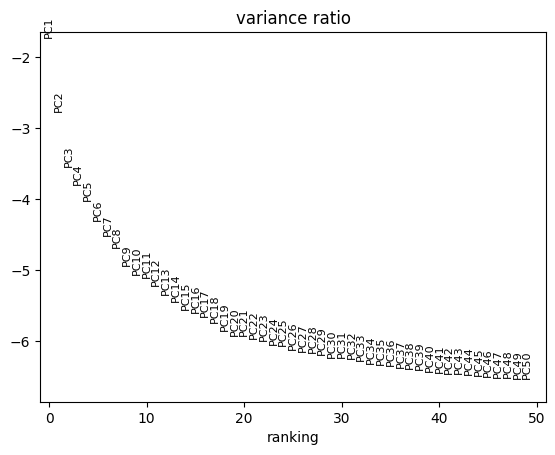

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

Top 21 PCs explain large fraction of variation or in other words retain a lot of information, while the rest of the PCs contain progressively less information. That said, it is still recommended to use more PCs since they can explain larger fraction of the variation and help to characterise rare cell types (e.g. platelets & DCs in this dataset).

### t-SNE

In [ ]:
sc.tl.tsne(adata, n_pcs = 30)

We plot t-SNE scatterplot colored by sample IDs. As you can see there is a clear pattern of batch effect (there are not much overlap among samples while these samples should have some overlap indicating similar cell types).

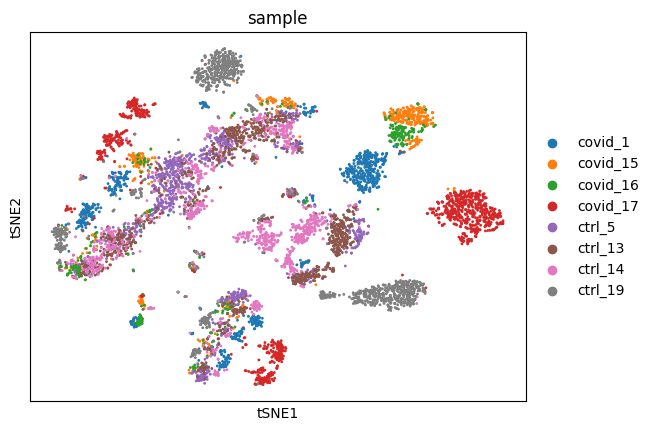

In [ ]:
sc.pl.tsne(adata, color=['sample'])

### UMAP

SCANPY uses a neighbourhood graph as the distance matrix, so we need to first calculate the graph.

In [ ]:
sc.pp.neighbors(adata, n_pcs=30, n_neighbors = 30)

Now we run UMAP for all cell embeddings.

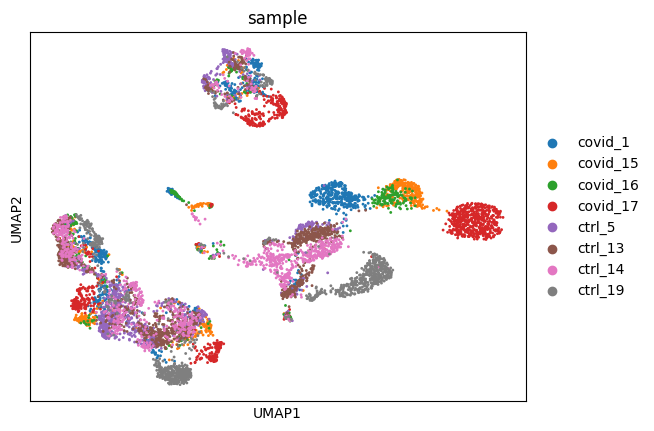

In [ ]:
sc.tl.umap(adata)
sc.pl.umap(adata, color = 'sample')

Here you can again see the batch effect.  
You can also select given number of components to calculate umap and also visualise neighbour edges, which shows the distance or connection among the cells dependent on their expression profile (?=??)

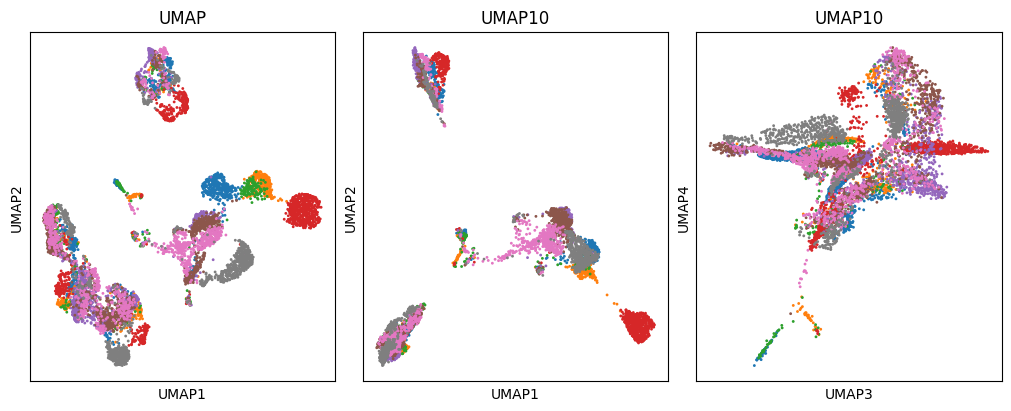

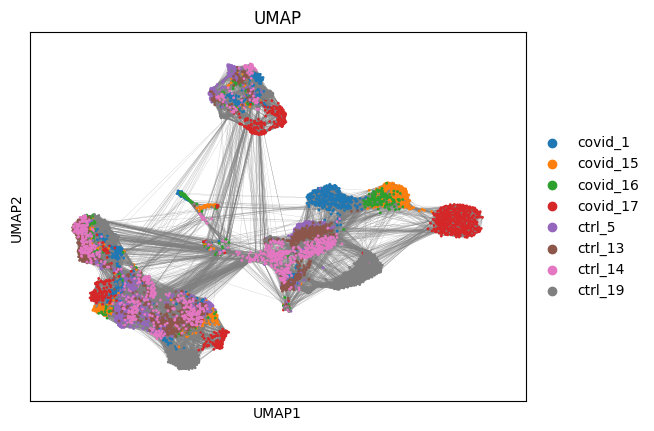

In [ ]:
# run with 10 components, save to a new object so that the umap with 2D is not overwritten.
umap10 = sc.tl.umap(adata, n_components=10, copy=True)
fig, axs = plt.subplots(1, 3, figsize=(10, 4), constrained_layout=True)

sc.pl.umap(adata, color='sample',  title="UMAP",
           show=False, ax=axs[0], legend_loc=None)
sc.pl.umap(umap10, color='sample', title="UMAP10", show=False,
           ax=axs[1], components=['1,2'], legend_loc=None)
sc.pl.umap(umap10, color='sample', title="UMAP10",
           show=False, ax=axs[2], components=['3,4'], legend_loc=None)

# we can also plot the umap with neighbor edges
sc.pl.umap(adata, color='sample', title="UMAP", edges=True)

Now let's compare different approaches for dimensionality reduction (PCA, t-SNE, and UMAP).
Probably one of the main conclusion is presence of the batch effect and can have a strong impact on downstream analysis (differential gene expression).

<Axes: title={'center': 'sample'}, xlabel='UMAP1', ylabel='UMAP2'>

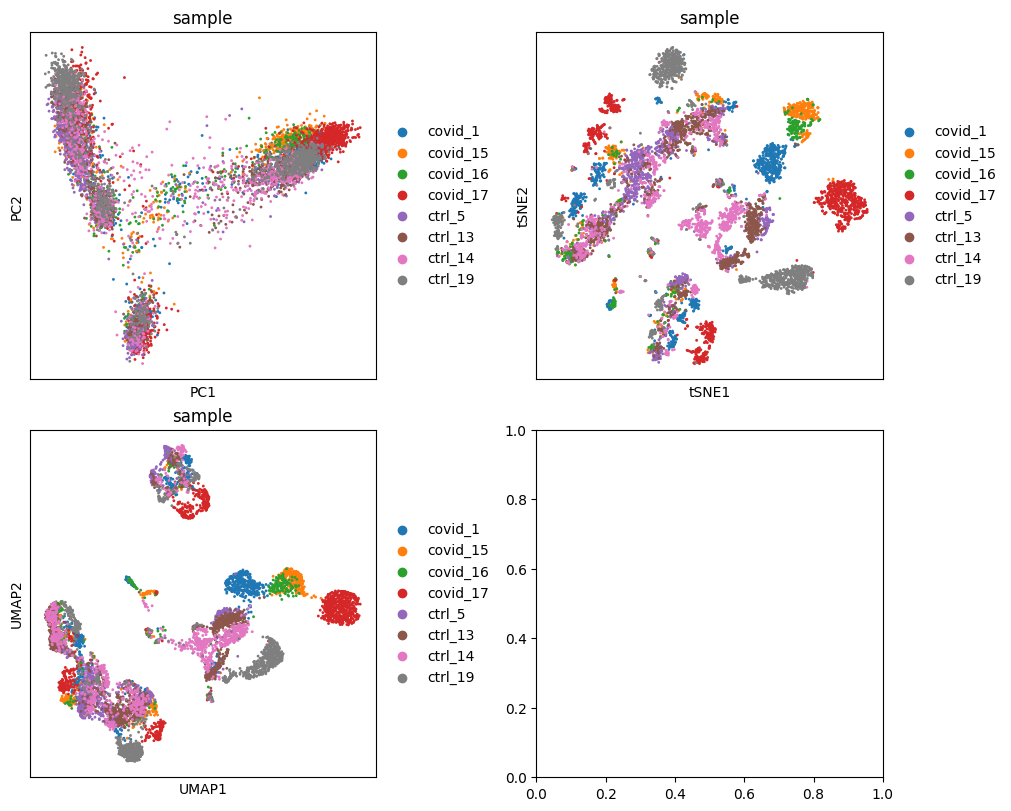

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)
sc.pl.pca(adata, color='sample', components=['1,2'], ax=axs[0, 0], show=False)
sc.pl.tsne(adata, color='sample', components=['1,2'], ax=axs[0, 1], show=False)
sc.pl.umap(adata, color='sample', components=['1,2'], ax=axs[1, 0], show=False)

### ⭐ **Task**

What else can you see? Do you see any difference or similarity? Write down your observations below.

`⭐ Edit this cell to write your answers below:`

-

Now we can visulaise QC metrics in the generated UMAP.

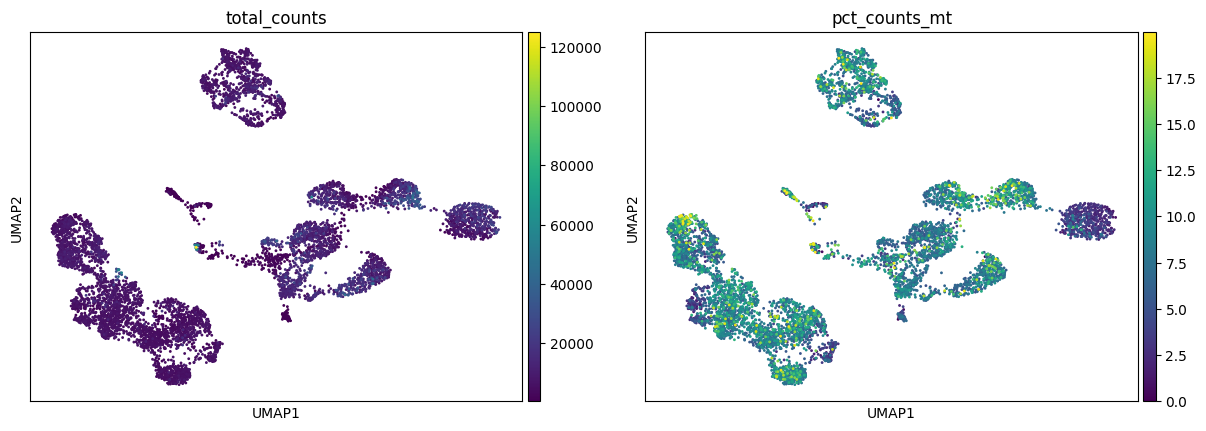

In [ ]:
sc.pl.umap(
    adata,
    color=["total_counts", "pct_counts_mt"],
)

Or visualise genes of interest

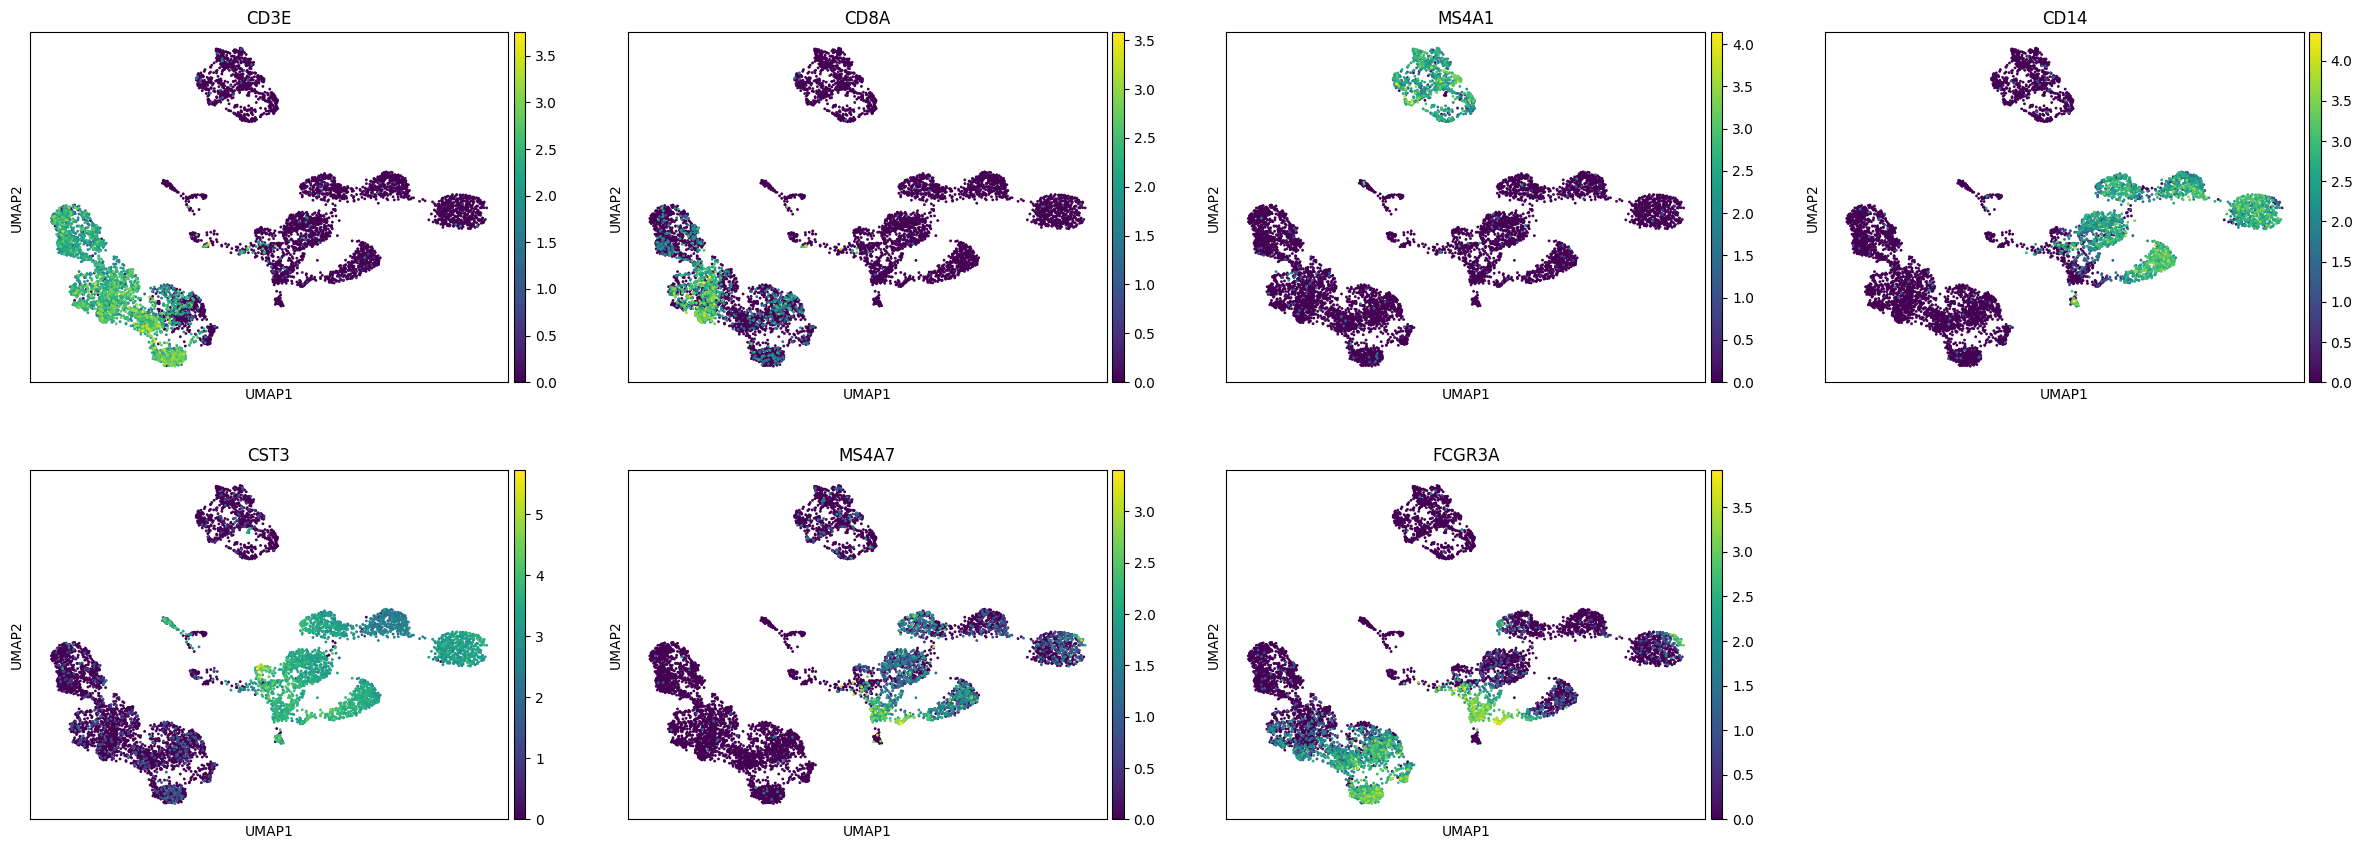

In [ ]:
sc.pl.umap(adata,
           color=["CD3E", "CD8A", "MS4A1","CD14",
                  "CST3","MS4A7","FCGR3A"])

Saving the object.

In [ ]:
adata.write_h5ad(os.path.join(path_results, "covid_filtered_removed_doublets_dr.h5ad"))

## Data Integration (Batch correction)

In [ ]:
adata2 = adata.raw.to_adata()

# in some versions of Anndata there is an issue with information on the logtransformation in the slot log1p.base so we set it to None to not get errors.
adata2.uns['log1p']['base']=None

# check that the matrix looks like normalized counts
print(adata2.X[1:10,1:10])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2 stored elements and shape (9, 9)>
  Coords	Values
  (0, 3)	0.7826338246821452
  (7, 6)	1.1311041336746985


### Detection of variable genes

In [ ]:
var_genes_all = adata.var.highly_variable

print("Highly variable genes: %d"%sum(var_genes_all))

Highly variable genes: 2616


Now, we extract variable genes in each sample using `batch_key` parameter.

In [ ]:
sc.pp.highly_variable_genes(adata2, min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key = 'sample')

print("Highly variable genes intersection: %d"%sum(adata2.var.highly_variable_intersection))

print("Number of batches where gene is variable:")
print(adata2.var.highly_variable_nbatches.value_counts())

var_genes_batch = adata2.var.highly_variable_nbatches > 0

Highly variable genes intersection: 122
Number of batches where gene is variable:
highly_variable_nbatches
0    7526
1    4126
2    3179
3    2022
4    1109
5     559
6     276
7     175
8     122
Name: count, dtype: int64


In [ ]:
print("Any batch var genes: %d"%sum(var_genes_batch))
print("All data var genes: %d"%sum(var_genes_all))
print("Overlap: %d"%sum(var_genes_batch & var_genes_all))
print("Variable genes in all batches: %d"%sum(adata2.var.highly_variable_nbatches == 6))
print("Overlap batch instersection and all: %d"%sum(var_genes_all & adata2.var.highly_variable_intersection))

Any batch var genes: 11568
All data var genes: 2616
Overlap: 2615
Variable genes in all batches: 276
Overlap batch instersection and all: 122


Select all genes that are variable in at least 2 datasets and use for remaining analysis.

In [ ]:
var_select = adata2.var.highly_variable_nbatches > 2
var_genes = var_select.index[var_select]
len(var_genes)

4263

### Harmony

We use `Harmony`  to integrate the data.  

In [ ]:
sce.pp.harmony_integrate(adata2, 'sample')

adata2.obsm['X_pca'] = adata2.obsm['X_pca_harmony']
sc.pp.neighbors(adata2, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata2)
sc.tl.leiden(adata2, resolution=0.5)

2025-09-16 14:07:11,735 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-09-16 14:07:16,430 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-09-16 14:07:16,483 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-09-16 14:07:18,942 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-09-16 14:07:21,366 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-09-16 14:07:23,799 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-09-16 14:07:25,031 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-09-16 14:07:28,546 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-09-16 14:07:29,316 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-09-16 14:07:30,229 - 

Now we  replot the UMAP after integration. You can see that the cells have been overlap.

<Axes: title={'center': 'Uncorrected umap'}, xlabel='UMAP1', ylabel='UMAP2'>

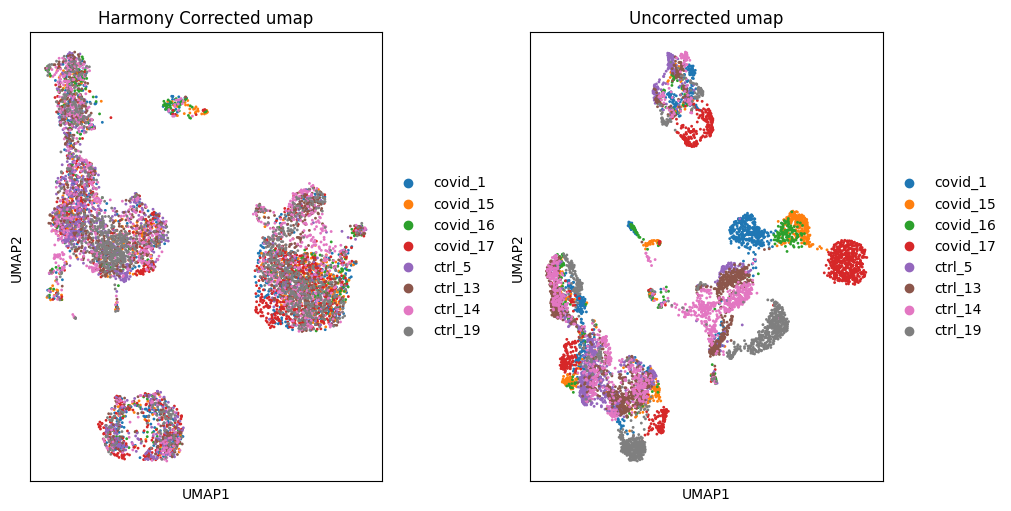

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,5),constrained_layout=True)
sc.pl.umap(adata2, color="sample", title="Harmony Corrected umap", ax=axs[0], show=False)
sc.pl.umap(adata, color="sample", title="Uncorrected umap", ax=axs[1], show=False)

Let’s save the integrated data for further analysis.

In [ ]:
adata2.write_h5ad(os.path.join(path_results, "covid_filtered_removed_doublets_dr_harmony.h5ad"))

### BBKNN

BBKNN (Batch Balanced K-Nearest Neighbors) is another method used in the analysis of single-cell RNA sequencing (scRNA-seq) data to address batch effects during dimensionality reduction and clustering.

In [ ]:
adata_bbkn = adata.raw.to_adata()

# in some versions of Anndata there is an issue with information on the logtransformation in the slot log1p.base so we set it to None to not get errors.
adata_bbkn.uns['log1p']['base']=None

bbknn.bbknn(adata_bbkn,batch_key='sample')

# then run umap on the integrated space
sc.tl.umap(adata_bbkn)
sc.tl.tsne(adata_bbkn)

Plots

<Axes: title={'center': 'Uncorrected umap'}, xlabel='UMAP1', ylabel='UMAP2'>

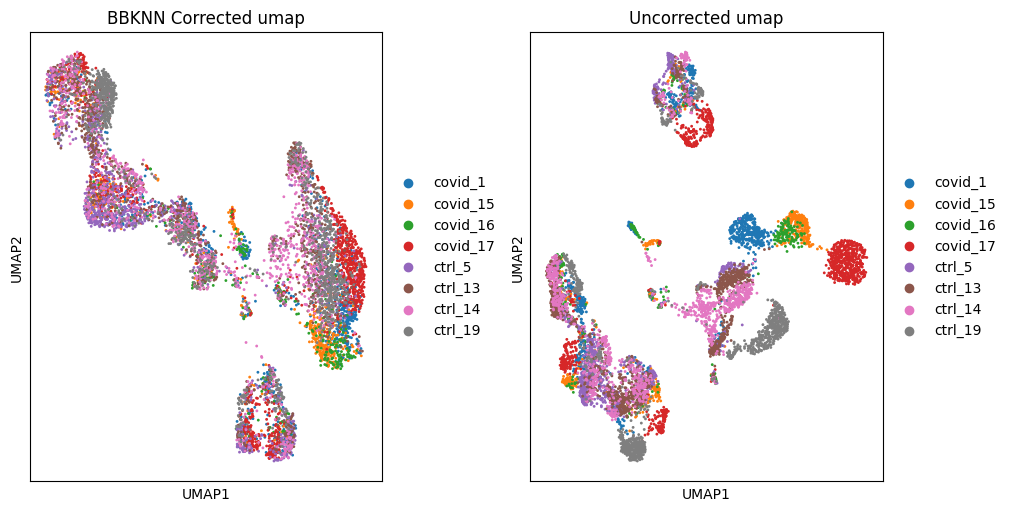

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,5),constrained_layout=True)
sc.pl.umap(adata_bbkn, color="sample", title="BBKNN Corrected umap", ax=axs[0], show=False)
sc.pl.umap(adata, color="sample", title="Uncorrected umap", ax=axs[1], show=False)

Let’s save the integrated data for further analysis.

In [ ]:
adata2.write_h5ad(os.path.join(path_results, "covid_filtered_removed_doublets_dr_bbknn.h5ad"))

### Combat
Batch correction can also be performed using `ComBat`, a method widely used for batch effect correction in both scRNASeq and bulk RNASeq data. It's important to note that `ComBat` requires the input data to be in a dense matrix format, which is already the case in this example.

In [ ]:
# create a new object with lognormalized counts
adata_combat = sc.AnnData(X=adata.raw.X, var=adata.raw.var, obs = adata.obs)

# first store the raw data
adata_combat.raw = adata_combat

# run combat
sc.pp.combat(adata_combat, key='sample')

To generate figures we require to rerun the standard steps as before:
- Vairable gene selection
- Calculating PCs
- t-SNE & UMAP

Highly variable genes: 3702


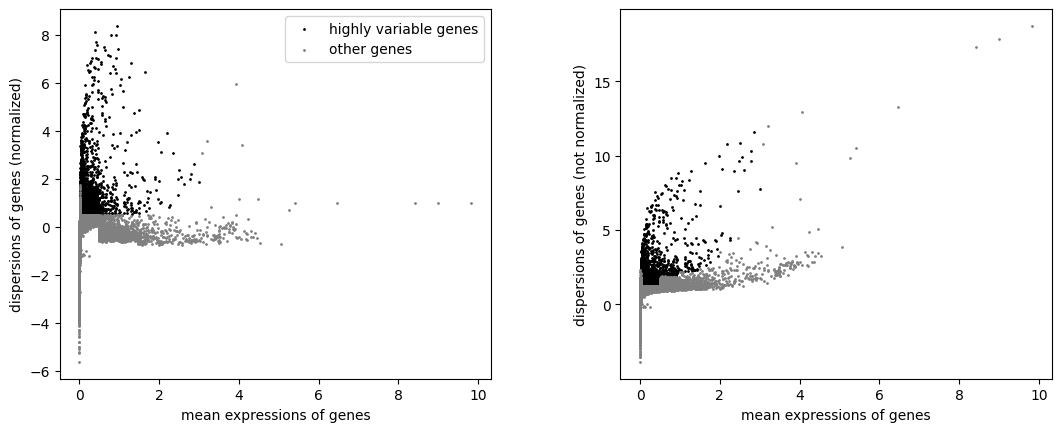

In [ ]:
sc.pp.highly_variable_genes(adata_combat)
print("Highly variable genes: %d"%sum(adata_combat.var.highly_variable))
sc.pl.highly_variable_genes(adata_combat)

sc.pp.pca(adata_combat, n_comps=30, use_highly_variable=True, svd_solver='arpack')

sc.pp.neighbors(adata_combat)

sc.tl.umap(adata_combat)
sc.tl.tsne(adata_combat)

We plot integrated and unintegrated data by using `ComBat`.

<Axes: title={'center': 'Uncorrected umap'}, xlabel='UMAP1', ylabel='UMAP2'>

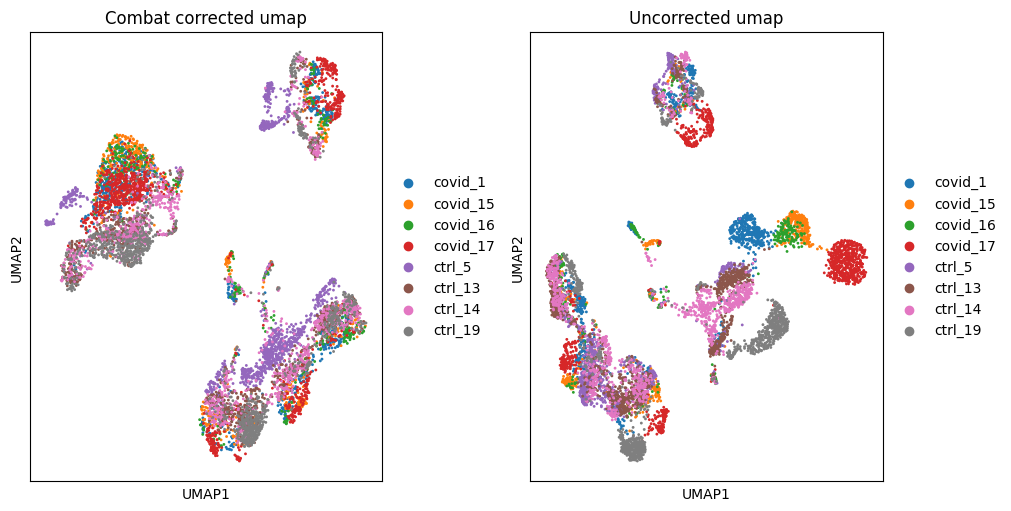

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,5),constrained_layout=True)
sc.pl.umap(adata_combat, color="sample", title="Combat corrected umap", ax=axs[0], show=False)
sc.pl.umap(adata, color="sample", title="Uncorrected umap", ax=axs[1], show=False)

Let’s save the integrated data for further analysis.

In [ ]:
adata2.write_h5ad(os.path.join(path_results, "covid_filtered_removed_doublets_dr_combat.h5ad"))

Now let's plot the output of all of the integration methods

<Axes: title={'center': 'Uncorrected umap'}, xlabel='UMAP1', ylabel='UMAP2'>

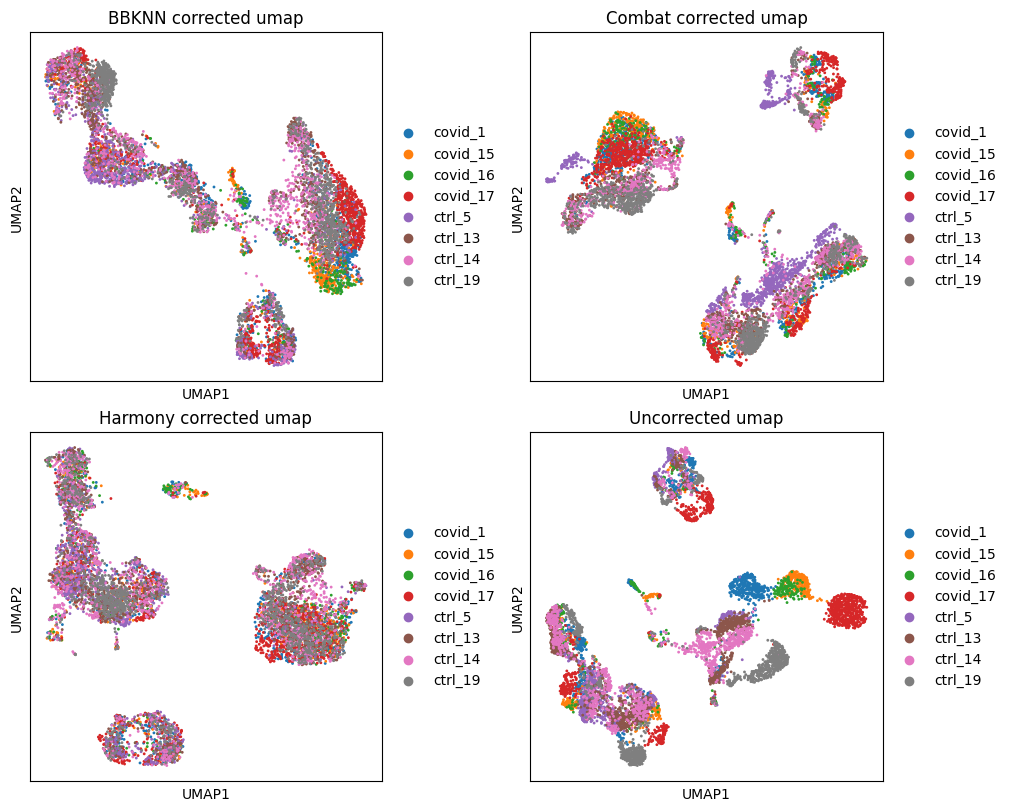

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10,8),constrained_layout=True)
sc.pl.umap(adata_bbkn, color="sample", title="BBKNN corrected umap", ax=axs[0,0], show=False)
sc.pl.umap(adata_combat, color="sample", title="Combat corrected umap", ax=axs[0,1], show=False)
sc.pl.umap(adata2, color="sample", title="Harmony corrected umap", ax=axs[1,0], show=False)
sc.pl.umap(adata, color="sample", title="Uncorrected umap", ax=axs[1,1], show=False)

## Clustering
Clustering is an unsupervised machine learning problem. We lable clusters by minimizing the intra-cluster distance in the reduced expression space. In this exercise, we use Leiden algorithm for clustering which is an improved version of Louvian algorithm (read more [here]()).

There are different approaches in clustering:
- Graph-based:
- K-means:
- Hierarchical:

**NOTE:** Louvian algorithm is no longer maintained.

It is done in three steps:  
- Build a kNN graph from the data.  
- Prune spurious connections from kNN graph (optional step). This is a SNN graph.  
- Find groups of cells that maximizes the connections within the group compared other groups.  

If you recall from the integration, we already constructed a knn graph before running UMAP. Hence we do not need to do it again, and can run the community detection right away.

The modularity optimization algoritm in Scanpy are Leiden and Louvain. Lets test both and see how they compare.

**NOTE:** Please note that we will be working with `harmony` integration output

### Leiden


In [ ]:
# Loading the anndata with integration by harmony
adata = sc.read_h5ad(os.path.join(path_results, "covid_filtered_removed_doublets_dr_harmony.h5ad"))

In [ ]:
sc.tl.leiden(adata, key_added = "leiden_1.0") # default resolution in 1.0
sc.tl.leiden(adata, resolution = 0.6, key_added = "leiden_0.6")
sc.tl.leiden(adata, resolution = 0.4, key_added = "leiden_0.4")
sc.tl.leiden(adata, resolution = 1.4, key_added = "leiden_1.4")

Plot the clusters: As you can observe, increasing the resolution results in finer granularity within the clustering, allowing for more detailed separation of cell groups. But you need to back it up by biological information you have.

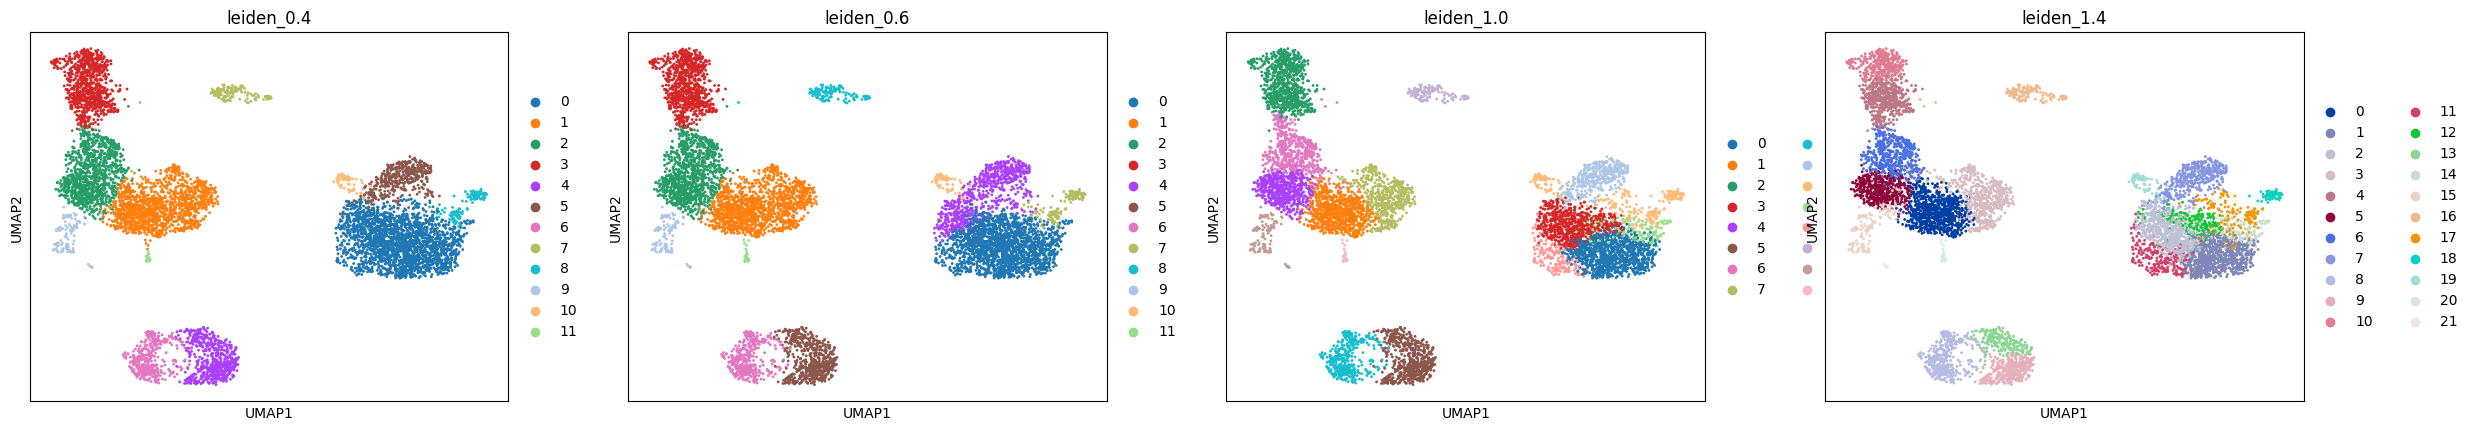

In [ ]:
sc.pl.umap(adata, color=['leiden_0.4', 'leiden_0.6', 'leiden_1.0','leiden_1.4'])

We can show the relationship between clusters by claculating correlation in PCA space.

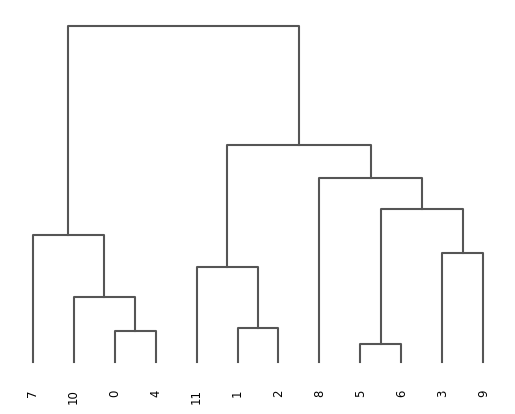

<Axes: >

In [ ]:
sc.tl.dendrogram(adata, groupby = "leiden_0.6")
sc.pl.dendrogram(adata, groupby = "leiden_0.6")

Try to do the same for other resolutions.

As explained above using prior biological information about the system you are studying can come in hand to evaluate the clustering output. For example you can visualise expression of marker genes. Try to do that by using the same genes used in domensionality reduction step.

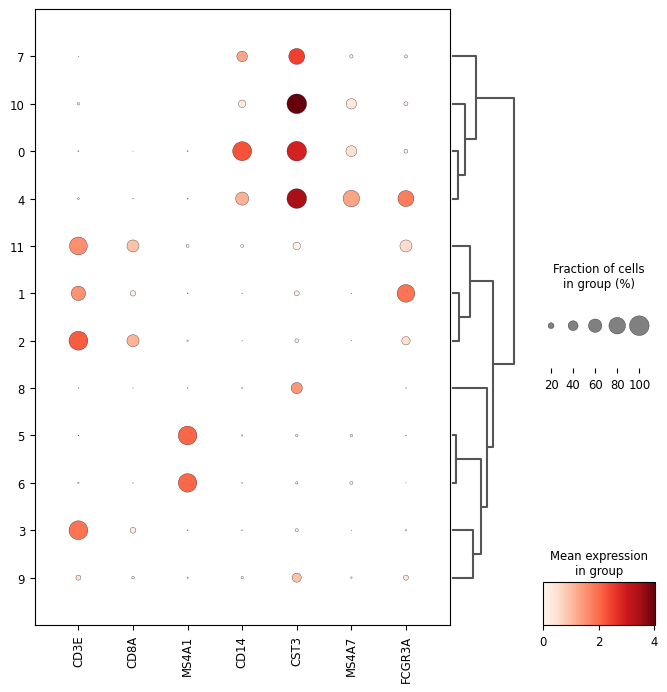

In [ ]:
genes = ["CD3E", "CD8A", "MS4A1","CD14",
                  "CST3","MS4A7","FCGR3A"]
sc.pl.dotplot(adata, genes, groupby='leiden_0.6', dendrogram=True, figsize=(8, 8))

### K-means
In this approach, we first set the number of clusters. It is recommended to run K-means with multiple starting configurations.  

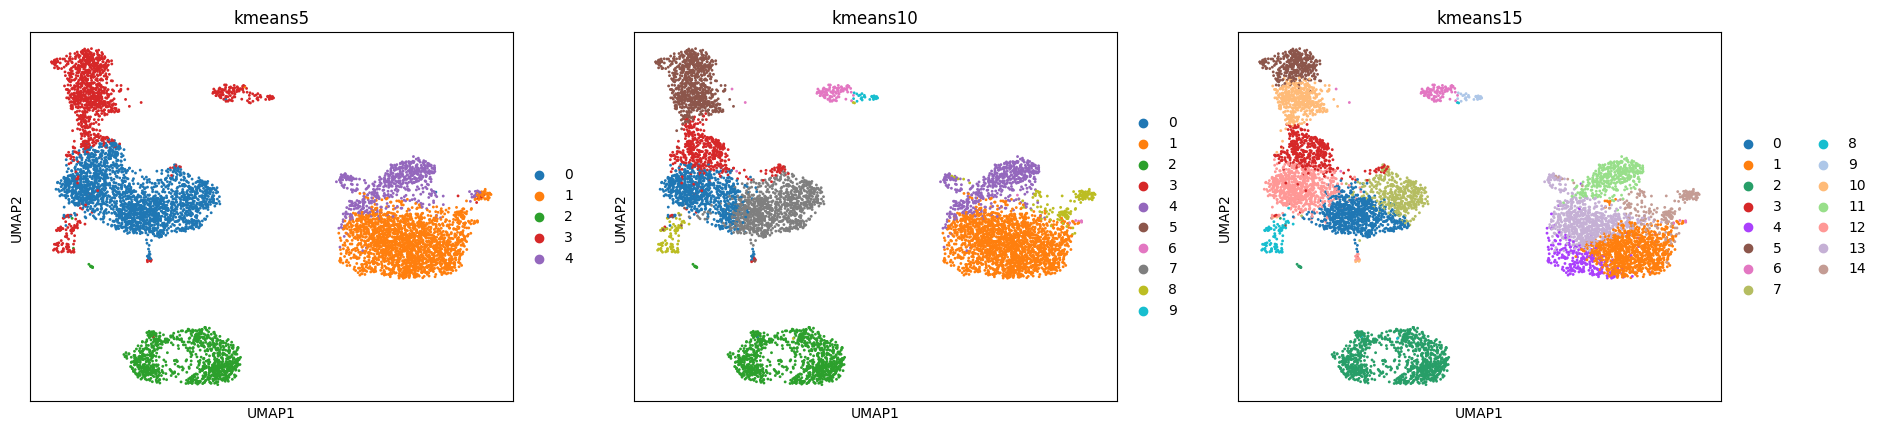

AxisArrays with keys: X_pca, X_pca_harmony, X_tsne, X_umap

In [ ]:
# extract pca coordinates
X_pca = adata.obsm['X_pca_harmony']

# kmeans with k=5
kmeans = KMeans(n_clusters=5, random_state=0).fit(X_pca)
adata.obs['kmeans5'] = kmeans.labels_.astype(str)

# kmeans with k=10
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_pca)
adata.obs['kmeans10'] = kmeans.labels_.astype(str)

# kmeans with k=15
kmeans = KMeans(n_clusters=15, random_state=0).fit(X_pca)
adata.obs['kmeans15'] = kmeans.labels_.astype(str)

sc.pl.umap(adata, color=['kmeans5', 'kmeans10', 'kmeans15'])

adata.obsm

### Hierarchical clustering
This method returns higherarchy of partitionings (a dendrogram) that can be cut at different levels in following steps:  
- Calculating distance between **samples** (cells in this case). This distance can be Euclidean distance or corrleation.    
- Defining a measure of distance between **clusters**.  (e.g. `linkage`, `single`, `average` , `median`, `centroid` and `ward`).  
- Defining the dendrogram among all samples using **Bottom-up** or **Top-down** approach. Bottom-up is where samples start with their own cluster which end up merged pair-by-pair until only one cluster is left. Top-down is where samples start all in the same cluster that end up being split by 2 until each sample has its own cluster.   


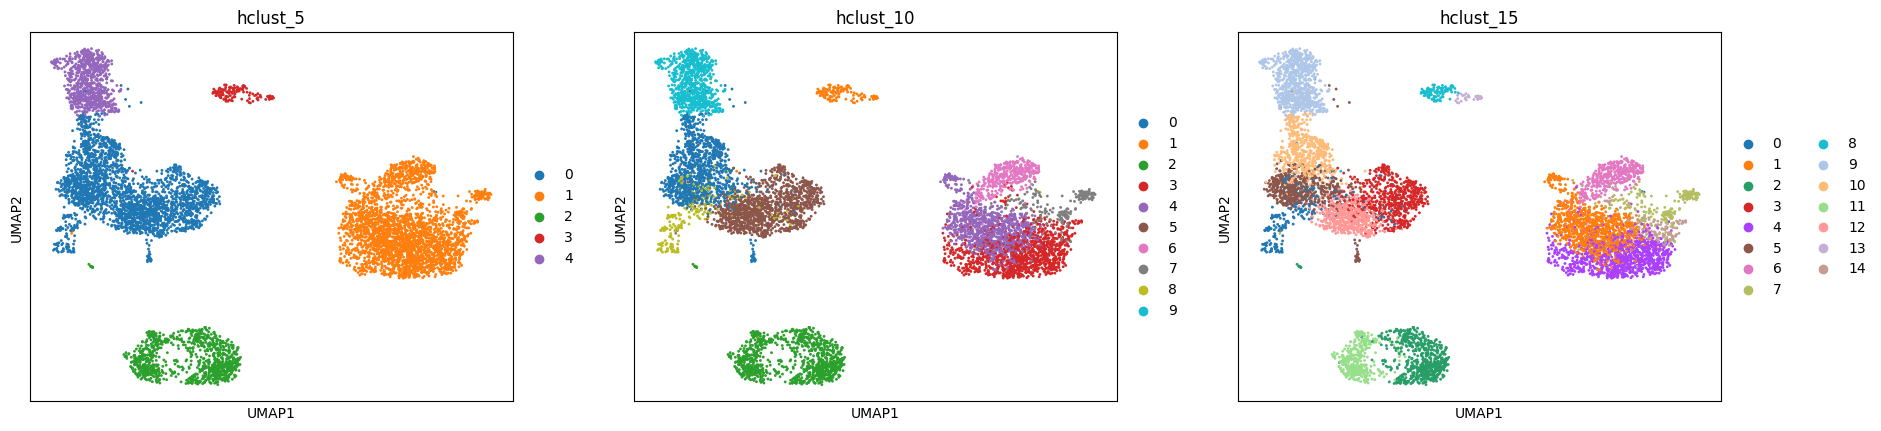

In [ ]:
cluster = AgglomerativeClustering(n_clusters=5, linkage='ward')
adata.obs['hclust_5'] = cluster.fit_predict(X_pca).astype(str)

cluster = AgglomerativeClustering(n_clusters=10, linkage='ward')
adata.obs['hclust_10'] = cluster.fit_predict(X_pca).astype(str)

cluster = AgglomerativeClustering(n_clusters=15, linkage='ward')
adata.obs['hclust_15'] = cluster.fit_predict(X_pca).astype(str)

sc.pl.umap(adata, color=['hclust_5', 'hclust_10', 'hclust_15'])

We now save the clustered data for further analysis.

In [ ]:
adata.write_h5ad(os.path.join(path_results, "covid_filtered_removed_doublets_dr_harmony_cl.h5ad"))

*****

# Part II — MCP + Gemini CLI

Now that we have preprocessed our data we can perform differential gene expression analysis. For this part of the analysis, you will start a VS Code Tunnel from the current notebook, which already has all necessary packages installed, and continue working in VS Code.

After the tunnel is started, go back to the [module 4 lab page](https://ddls.aicell.io/course/ddls-2025/module-4/lab/) and follow the instructions there.


## Install VS Code Tunnel

Visual Studio Code (VS Code) is a very popular and powerful code editor that offers many features for writing and debugging code. While Google Colab provides a coding environment, many developers prefer the experience of working in VS Code.

To still use Google Colab's free computing resources while enjoying the benefits of VS Code, you can install the VS Code Tunnel. This creates a secure connection between your Colab session and your local VS Code application, allowing you to edit files and run code directly within VS Code, while the processing happens in your Colab notebook.

In [ ]:
!curl -Lk 'https://code.visualstudio.com/sha/download?build=stable&os=cli-alpine-x64' --output vscode_cli.tar.gz
!tar -xf vscode_cli.tar.gz

## Start VS Code Tunnel

After downloading the VS Code CLI, you need to click the **Terminal** button in the bottom of this page.

Then, in the terminal, type:
```
./code tunnel
```

Then follow the instructions, use your arrow keys to select `❯ GitHub Account`, then you will see something like:

> To grant access to the server, please log into https://github.com/login/device and use code B6BB-23AA

You should now copy the url and open in a new browser tab, then copy the device code to login, you will need to approve the access to your github account then return to this terminal.

Then you will see something like, and type e.g. `colab` for the name to identify this machine:
> ? What would you like to call this machine? (30d8d79434a3) › colab

After that you should see:
> Open this link in your browser https://vscode.dev/tunnel/colab/content


Now visit the link and you should get the vscode session where you will work on.

**Importantly, please keep the terminal open and the browser tab for google colab active during the whole time.**

To prevent the Colab session from timing out, you can run the code cell below. It will simulate activity every 5 minutes.

In [ ]:
import time
from datetime import datetime

while True:
    # Print something every 5 minutes so Colab sees activity
    now = datetime.now().strftime("%H:%M:%S")
    print(f"✅ Still alive... ({now})")
    time.sleep(300)